In [ ]:
import os
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

print("Libraries imported successfully!")

Libraries imported successfully!


In [ ]:
path = kagglehub.dataset_download("gti-upm/leapgestrecog")

print("Path to dataset files:", path)
dataset_dir = os.path.join(path, "leapGestRecog")
if not os.path.exists(dataset_dir):
    dataset_dir = path
print("Working Dataset Directory:", dataset_dir)

Using Colab cache for faster access to the 'leapgestrecog' dataset.
Path to dataset files: /kaggle/input/leapgestrecog
Working Dataset Directory: /kaggle/input/leapgestrecog/leapGestRecog


In [ ]:
file_paths = []
labels = []
subjects = []

for folder in os.listdir(dataset_dir):
    folder_path = os.path.join(dataset_dir, folder)
    if os.path.isdir(folder_path):
        subject_id = folder

        for gesture in os.listdir(folder_path):
            gesture_path = os.path.join(folder_path, gesture)
            if os.path.isdir(gesture_path):
                gesture_name = gesture.split('_')[-1]

                for image in os.listdir(gesture_path):
                    image_path = os.path.join(gesture_path, image)
                    file_paths.append(image_path)
                    labels.append(gesture_name)
                    subjects.append(subject_id)

df = pd.DataFrame({'filepath': file_paths, 'label': labels, 'subject': subjects})
print(f"Total images: {len(df)}")
print(f"Unique Subjects: {df['subject'].unique()}")

Total images: 20000
Unique Subjects: ['07' '05' '06' '02' '04' '00' '08' '09' '03' '01']


In [ ]:
unique_subjects = df['subject'].unique()
train_subs = ['00', '01', '02', '03', '04', '05', '06', '07']
val_subs = ['08']
test_subs = ['09']

train_df = df[df['subject'].isin(train_subs)]
val_df = df[df['subject'].isin(val_subs)]
test_df = df[df['subject'].isin(test_subs)]

print(f"Train samples: {len(train_df)} | Val samples: {len(val_df)} | Test samples: {len(test_df)}")

Train samples: 16000 | Val samples: 2000 | Test samples: 2000


In [ ]:
train_df, temp_df = train_test_split(df, train_size=0.8, shuffle=True, random_state=42, stratify=df['label'])

val_df, test_df = train_test_split(temp_df, train_size=0.5, shuffle=True, random_state=42, stratify=temp_df['label'])

print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")

Training set size: 16000
Validation set size: 2000
Test set size: 2000


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.4,
    horizontal_flip=True,
    brightness_range=[0.6, 1.4],
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.resnet50.preprocess_input
)

train_gen = train_datagen.flow_from_dataframe(
    train_df, x_col='filepath', y_col='label',
    target_size=(224, 224),
    batch_size=64 ,
    class_mode='categorical'
)
val_gen = val_test_datagen.flow_from_dataframe(
    val_df, x_col='filepath', y_col='label',
    target_size=(224, 224), batch_size=16, class_mode='categorical'
)

Found 16000 validated image filenames belonging to 9 classes.
Found 2000 validated image filenames belonging to 9 classes.


In [ ]:
from tensorflow.keras import regularizers

num_classes = len(train_gen.class_indices)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)

x = Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.6)(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.5)(x)

predictions = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
history = model.fit(
    train_gen,
    steps_per_epoch=200,
    validation_data=val_gen,
    validation_steps=50,
    epochs=10,
    callbacks=[early_stop, reduce_lr]
)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 233s 1s/step - accuracy: 0.2560 - loss: 12.6791 - val_accuracy: 0.8163 - val_loss: 8.5068 - learning_rate: 1.0000e-04
Epoch 2/10
 50/200 ━━━━━━━━━━━━━━━━━━━━ 2:32 1s/step - accuracy: 0.5812 - loss: 8.7957

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


200/200 ━━━━━━━━━━━━━━━━━━━━ 54s 270ms/step - accuracy: 0.5857 - loss: 8.6558 - val_accuracy: 0.8400 - val_loss: 7.6811 - learning_rate: 1.0000e-04
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 211s 1s/step - accuracy: 0.6594 - loss: 7.5201 - val_accuracy: 0.9375 - val_loss: 5.4918 - learning_rate: 1.0000e-04
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 54s 270ms/step - accuracy: 0.7632 - loss: 5.7274 - val_accuracy: 0.9450 - val_loss: 5.0967 - learning_rate: 1.0000e-04
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 213s 1s/step - accuracy: 0.7854 - loss: 5.1759 - val_accuracy: 0.9538 - val_loss: 3.9520 - learning_rate: 1.0000e-04
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 53s 267ms/step - accuracy: 0.8278 - loss: 4.1926 - val_accuracy: 0.9538 - val_loss: 3.7367 - learning_rate: 1.0000e-04
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 209s 1s/step - accuracy: 0.8403 - loss: 3.8559 - val_accuracy: 0.9588 - val_loss: 3.0438 - learning_rate: 1.0000e-04
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 53s 265ms/step - accura

63/63 ━━━━━━━━━━━━━━━━━━━━ 19s 266ms/step - accuracy: 0.9762 - loss: 2.2843

Test Accuracy: 97.45%
Test Loss: 2.2846


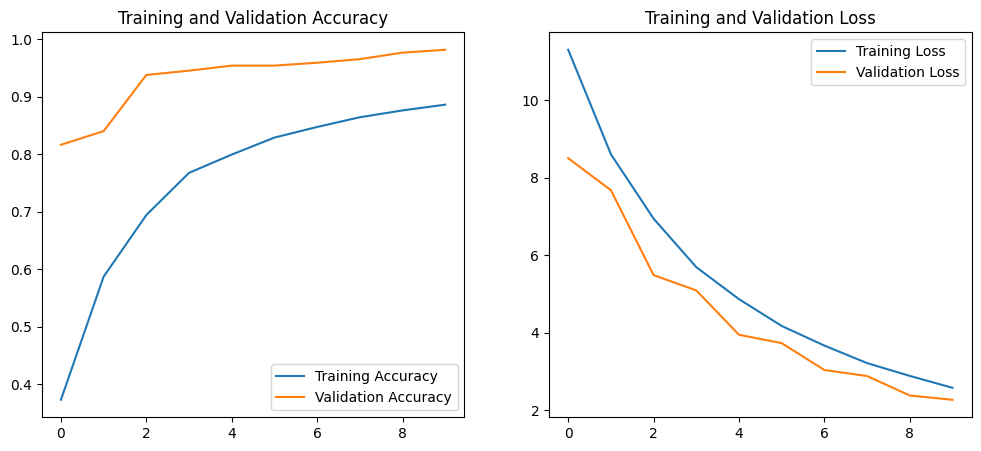

In [ ]:
test_loss, test_acc = model.evaluate(test_gen)
print(f"\nTest Accuracy: {test_acc*100:.2f}%")
print(f"Test Loss: {test_loss:.4f}")

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 5))

# Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()